### Adjacency matrix as transit route constellation

Consider this an art project, rather than any sort of useful analysis. I really want to make t-shirts out of these!

In [1]:
from collections import defaultdict
from gtfslib.dao import Dao
from gtfslib.model import CalendarDate
import itertools
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from natsort import natsorted
import networkx as nx
import random

%matplotlib inline

def pairwise(iterable):
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

In [2]:
dao = Dao('data/SFMTA-2017-02-21.sqlite')

In [3]:
timetables = defaultdict(lambda: defaultdict(set))
for trip in dao.trips(fltr=(CalendarDate.date=='2017-03-15')):
    pattern = tuple(st.stop_id for st in trip.stop_times)
    timetables[trip.route_id][trip.direction_id].add(pattern)

In [4]:
G = defaultdict(lambda: defaultdict(nx.DiGraph))
for route_id, directions in timetables.items():
    for direction_id, patterns in directions.items():
        for pattern in patterns:
            for a, b in pairwise(pattern):
                G[route_id][direction_id].add_edge(a, b)

In [5]:
def route_title(route):
    parts = [route.route_short_name, route.route_long_name, route.route_id]
    return " ".join(part for part in parts if part)

routes = natsorted([r for r in dao.routes() if r.route_id in G], key=route_title)

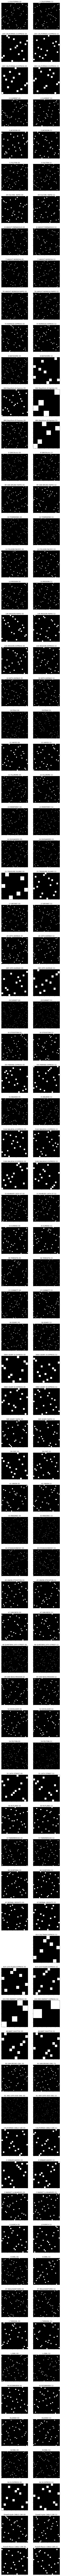

In [6]:
fig = plt.figure(figsize=(8, 360), dpi=80)
count = 0
for i, route in enumerate(routes, start=1):
    if any(G[route.route_id].values()):
        count += 2
    for j, (direction_id, g) in enumerate(sorted(G[route.route_id].items(), reverse=True)):
        ax = fig.add_subplot(len(routes), 2, count - j)

        # no ticks
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        # make it beautiful like the stars
        nodelist = list(g)
        random.shuffle(nodelist)

        A = nx.adjacency_matrix(g, nodelist=nodelist)

        title_parts = [route.route_short_name, route.route_long_name]
        title = '%s (%d)' % (' '.join(p for p in title_parts if p), direction_id)
        ax.title.set_text(title)


        ax.imshow(A.toarray(), cmap='Greys_r')